In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import datetime
from datetime import date
import random

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Part 1: Data Generation
- Since our DAPP is just a prototype, and the information we would track is not publicly available, we mocked up data
- this data does not take into account real-world distributions of immunization type or frequncies
    - however, we put half of the values as PCR tests since this is the most common form of immunity proof now and for the foreseeable future
- similarly, the travel destinations are dummy variables
- the data generation includes business logic for how to determine a travelers validity 
- this is also a good proxy for how the off-chain databases could be organized
- please refer to comments in the code for specific explanations of the logic if unclear from code itself

In [2]:
# this function generates n random dates within a range

def random_dates(start, end, l=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, l), unit='s')

In [3]:

#### IMMUNIZATION DATA ####

# lookup dict of immunization 3-character code and the full name
vax_desc = {'pcr':'PCR Test',
               'rec':'Proof Of Recovery',
               'jj':'Johnson & Johnson',
               'az1':'Astra-Zeneca Dose 1',
               'az2':'Astra-Zeneca Dose 2'}

# lookup dict of immunization 3-char code and the type of immunization
vax_id_type = {'pcr':'test',
               'rec':'rec',
               'jj':'vax',
               'az1':'vax1',
               'az2':'vax2'}

#  lookup dict of type of immunization and number of days of validity
vax_duration = {'test':3,'vax1':0,'vax2':365,'vax':365,'rec':180}

# unique list of all immunization 3-char codes
immunization_ids = [key for key,value in vax_id_type.items()]

In [19]:
### PATIENT DATA GENERATION ###

n_pa = 800 # number of total distinct patients in our sample
n = 1000 # number of immunization records in our sample

patient_id_unique = random.sample(range(10000, 99999), n_pa)
patient_ids = random.choices(patient_id_unique, k=n) # patients can get vaxed multiple times, so we resample
patient_immunization_ids = ['pcr']*(n//2) +random.choices(immunization_ids, k=(n//2)) # pretending that at least 50% of immunity proofs are PCR tests


In [20]:
### MEDICAL CENTER DATA GENERATION ####

# dummy list of cities, can add to this as records come in. This way we can look up country easily
cities = {'San Francisco':'USA',
          'New York':'USA',
          'Barcelona':'Spain',
          'Paris':'France',
          'London':'UK',
          'Milan':'Italy',
          'Dublin':'Ireland'
         }

med_center_id_unique = random.sample(range(1000, 9999), 30) # 30 total medical centers, assigning unique codes
med_center_cities = random.choices([c for c in cities.keys()], k=30) # randomly assigning cities for each center
med_center_countries = [cities[c] for c in med_center_cities] # look up country by city name

med_cen_ids = random.sample(range(10000, 90000), n) # assigning medical centers from unique list to each vax record

In [32]:
### IMMUNIZATION RECORD DATA GENERATION ###

# setting start date for when immunizations began. This can be changed. End is current day
start = pd.to_datetime('2021-01-01')
end = pd.to_datetime(date.today())

# randomly assigning a date within that range to every immunization
immunization_dates = random_dates(start, end,l=n)


In [33]:
# Immunization dimension table

vax_dims = {'id':immunization_ids,
            'name':[vax_desc[vid] for vid in immunization_ids],
            'type':[value for key,value in vax_id_type.items()],
            'immune_days':[vax_duration[key] for key in vax_id_type.values()]}

vax_dim_df = pd.DataFrame.from_dict(vax_dims)
vax_dim_df.to_csv('vax_types.csv')
vax_dim_df.head()

,id,name,type,immune_days
0,pcr,PCR Test,test,3
1,rec,Proof Of Recovery,rec,180
2,jj,Johnson & Johnson,vax,365
3,az1,Astra-Zeneca Dose 1,vax1,0
4,az2,Astra-Zeneca Dose 2,vax2,365


In [34]:
# immunization record table

vax_records = {'patient_id':patient_ids,
               'immunization_id': patient_immunization_ids,
               'immunization_date': immunization_dates,
               'medical_center_id': med_cen_ids}

vax_rec_df = pd.DataFrame.from_dict(vax_records)

# from the immunization length lookup, we set the data of validity of each immunization record 
vax_rec_df['immunization_validity_date']=vax_rec_df.apply(
    lambda x: x['immunization_date']+ datetime.timedelta(days=vax_duration[vax_id_type[x.immunization_id]]),axis=1)

vax_rec_df.to_csv('immunizations.csv')
vax_rec_df.head()

,patient_id,immunization_id,immunization_date,medical_center_id,immunization_validity_date
0,25086,pcr,2021-01-21 14:45:25,74994,2021-01-24 14:45:25
1,23878,pcr,2021-04-11 10:02:54,61962,2021-04-14 10:02:54
2,34402,pcr,2021-01-10 03:44:32,23773,2021-01-13 03:44:32
3,79946,pcr,2021-02-23 17:47:27,43413,2021-02-26 17:47:27
4,99585,pcr,2021-06-10 18:57:18,44736,2021-06-13 18:57:18


In [35]:

med_cen_records = {'med_center_id':med_center_id_unique,
                   'name':[f'Dummy Name {i}' for i in med_center_id_unique], # placeholder for actual names
                   'city': med_center_cities,
                   'country':med_center_countries}
med_cen_df = pd.DataFrame.from_dict(med_cen_records)

med_cen_df.to_csv('medical.csv')

med_cen_df.head()


,med_center_id,name,city,country
0,7673,Dummy Name 7673,Paris,France
1,6034,Dummy Name 6034,New York,USA
2,9762,Dummy Name 9762,Paris,France
3,4932,Dummy Name 4932,Barcelona,Spain
4,3540,Dummy Name 3540,San Francisco,USA


In [37]:
### TRAVEL DATA GENERATION ###

kn = 500 # 500 trips, we can change this 

# create to:from list from our existing list of cities, omitting where to and from is the same
from_to_combos = [[i,j] for j in cities for i in cities if i!=j]

# take kn samples from this list of possible routes
from_to = random.choices(from_to_combos, k=kn)


travel_records = {'customer_id':random.choices(patient_ids, k=kn), # choose from existing list of patients
                  'travel_date':random_dates(start, end,l=kn),
                  'from_city':[e[0] for e in from_to],
                  'to_city':[e[1] for e in from_to]
                 }

travel_df = pd.DataFrame.from_dict(travel_records)

# business logic for checking immunity status: find latest valid immunity date for each traveler
# check if that immunity date is before or after the travel date
travel_df['immunity_end_date'] = travel_df.apply(
    lambda x: vax_rec_df[vax_rec_df.patient_id == x.customer_id].immunization_validity_date.max(),axis=1)
travel_df['immunity_status'] = travel_df.apply(lambda x: True if x.immunity_end_date > x.travel_date else False, axis=1)

travel_df.to_csv('travel.csv')
travel_df['travel_month'] = travel_df.travel_date.dt.to_period('M')
travel_df.head()


,customer_id,travel_date,from_city,to_city,immunity_end_date,immunity_status,travel_month
0,39533,2021-01-28 09:28:34,Paris,San Francisco,2021-06-05 22:25:38,True,2021-01
1,52207,2021-04-29 14:35:58,London,New York,2022-06-05 13:21:14,True,2021-04
2,36636,2021-03-27 17:31:41,New York,Milan,2022-04-01 10:39:15,True,2021-03
3,66718,2021-02-05 06:22:27,San Francisco,New York,2022-02-04 06:39:14,True,2021-02
4,55244,2021-05-05 20:42:00,Dublin,London,2021-12-07 04:17:47,True,2021-05


<AxesSubplot:xlabel='travel_month', ylabel='count'>

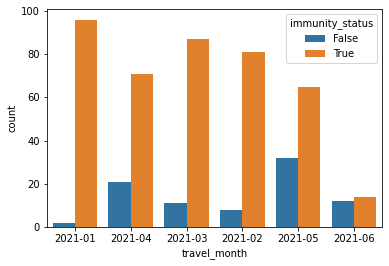

In [38]:

sns.countplot(data=travel_df, x="travel_month", hue="immunity_status")
